# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install swig
!pip install renderlab
!pip install gymnasium
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376095 sha256=92dff307773d0b458712371cbd2a53caad0136f8b643c362c7e521be43f0b852
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [2]:
import gymnasium as gym
import renderlab as rl
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import random
from collections import namedtuple, deque

import imageio
from IPython.display import Image

%matplotlib inline

  if event.key is 'enter':



### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [3]:
env = gym.make('LunarLander-v3', render_mode = "rgb_array")
# env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [4]:
env = rl.RenderFrame(env, "./output")

state = env.reset()
score = 0
for t in range(200):
    action = env.action_space.sample()
    state, reward, done, _, _ = env.step(action)
    score += reward
    if done:
        break

print('Final score:', score)
env.play()
env.close()

Final score: -310.0724329748193
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Before running the next code cell, familiarize yourself with the code in **Step 2** and **Step 3** of this notebook, along with the code in `dqn_agent.py` and `model.py`.  Once you have an understanding of how the different files work together,
- Define a neural network architecture in `model.py` that maps states to action values.  This file is mostly empty - it's up to you to define your own deep Q-network!
- Finish the `learn` method in the `Agent` class in `dqn_agent.py`.  The sampled batch of experience tuples is already provided for you; you need only use the local and target Q-networks to compute the loss, before taking a step towards minimizing the loss.

## Implement QNetwork

In [10]:
class QNetwork(nn.Module):
  """Actor (Policy) Model."""

  def __init__(self, state_size, action_size, seed):
    """Initialize parameters and build model.
    Params
    ======
      state_size (int): Dimension of each state
      action_size (int): Dimension of each action
      seed (int): Random seed
    """
    super(QNetwork, self).__init__()
    self.seed = torch.manual_seed(seed)
    "*** YOUR CODE HERE ***"
    self.l1 = nn.Linear(8, 128)
    self.l2 = nn.Linear(128, 128)
    self.l3 = nn.Linear(128, 4)

  def forward(self, state):
    """Build a network that maps state -> action values."""
    x1 = F.relu(self.l1(state))
    x2 = F.relu(self.l2(x1))
    x3 = self.l3(x2)

    return x3

## Implement DQN Agent

- Agent HyperParameters

In [11]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Class `ReplayBuffer`


In [12]:
class ReplayBuffer:
  """Fixed-size buffer to store experience tuples."""

  def __init__(self, action_size, buffer_size, batch_size, seed):
    """Initialize a ReplayBuffer object.

    Params
    ======
        action_size (int): dimension of each action
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch
        seed (int): random seed
    """
    self.action_size = action_size
    self.memory = deque(maxlen=buffer_size)
    self.batch_size = batch_size
    self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    self.seed = random.seed(seed)

  def add(self, state, action, reward, next_state, done):
    """Add a new experience to memory."""
    e = self.experience(state, action, reward, next_state, done)
    self.memory.append(e)

  def sample(self):
    """Randomly sample a batch of experiences from memory."""
    experiences = random.sample(self.memory, k=self.batch_size)

    states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

    return (states, actions, rewards, next_states, dones)

  def __len__(self):
    """Return the current size of internal memory."""
    return len(self.memory)

## Class `Agent`

In [13]:
class Agent():
  """Interacts with and learns from the environment."""

  def __init__(self, state_size, action_size, seed):
    """Initialize an Agent object.

    Params
    ======
        state_size (int): dimension of each state
        action_size (int): dimension of each action
        seed (int): random seed
    """
    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    # Q-Network
    self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
    self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
    self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

    # Replay memory
    self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
    # Initialize time step (for updating every UPDATE_EVERY steps)
    self.t_step = 0

  def step(self, state, action, reward, next_state, done):
    # Save experience in replay memory
    self.memory.add(state, action, reward, next_state, done)

    # Learn every UPDATE_EVERY time steps.
    self.t_step = (self.t_step + 1) % UPDATE_EVERY
    if self.t_step == 0:
      # If enough samples are available in memory, get random subset and learn
      if len(self.memory) > BATCH_SIZE:
        experiences = self.memory.sample()
        self.learn(experiences, GAMMA)

  def act(self, state, eps=0.):
    """Returns actions for given state as per current policy.

    Params
    ======
        state (array_like): current state
        eps (float): epsilon, for epsilon-greedy action selection
    """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.qnetwork_local.eval()
    with torch.no_grad():
      action_values = self.qnetwork_local(state)
    self.qnetwork_local.train()

    # Epsilon-greedy action selection
    if random.random() > eps:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

  def learn(self, experiences, gamma):
    """Update value parameters using given batch of experience tuples.

    Params
    ======
        experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
        gamma (float): discount factor
    """
    states, actions, rewards, next_states, dones = experiences

    ## TODO: compute and minimize the loss
    "*** YOUR CODE HERE ***"

    local_val = self.qnetwork_local(states).gather(1, actions)

    target_val_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
    # done이면 next Q value가 없다.
    target_val = rewards + gamma * target_val_next * (1 - dones)

    loss = F.mse_loss(local_val, target_val)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # ------------------- update target network ------------------- #
    self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

  def soft_update(self, local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target

    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


Once you have completed the code in `dqn_agent.py` and `model.py`, run the code cell below.  (_If you end up needing to make multiple changes and get unexpected behavior, please restart the kernel and run the cells from the beginning of the notebook!_)

You can find the solution files, along with saved model weights for a trained agent, in the `solution/` folder.  (_Note that there are many ways to solve this exercise, and the "solution" is just one way of approaching the problem, to yield a trained agent._)

In [14]:
agent = Agent(state_size=8, action_size=4, seed=0)

# watch an untrained agent
state, _ = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    state, reward, done, truncated, info = env.step(action)
    if done or truncated:
        break

env.close()

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Episode 100	Average Score: -142.02
Episode 200	Average Score: -101.18
Episode 300	Average Score: -65.36
Episode 400	Average Score: -11.62
Episode 500	Average Score: 70.57
Episode 592	Average Score: 200.95
Environment solved in 492 episodes!	Average Score: 200.95


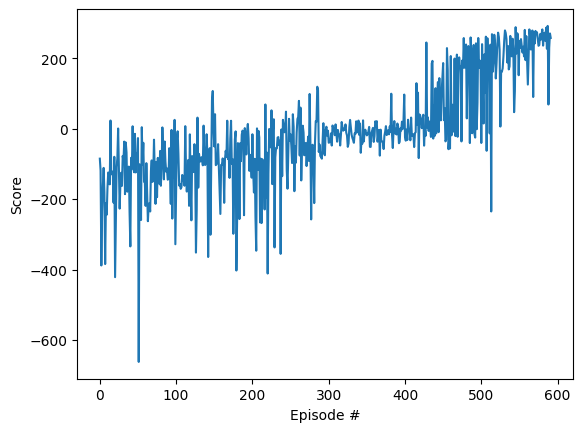

In [15]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, truncated, info = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done or truncated:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'my_checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [19]:
!wget https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/checkpoint.pth

--2024-10-28 01:55:32--  https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/checkpoint.pth
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘checkpoint.pth’

checkpoint.pth          [  <=>               ] 287.58K  1.16MB/s    in 0.2s    

2024-10-28 01:55:32 (1.16 MB/s) - ‘checkpoint.pth’ saved [294477]



  agent_sol.qnetwork_local.load_state_dict(torch.load('my_checkpoint.pth'))



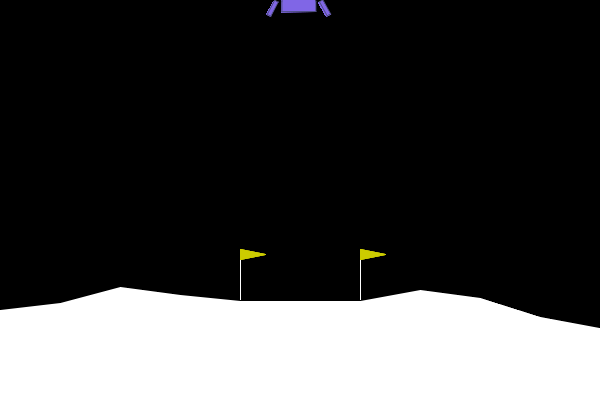

In [22]:
# load the weights from file
agent_sol = Agent(state_size=8, action_size=4, seed=0)
agent_sol.qnetwork_local.load_state_dict(torch.load('my_checkpoint.pth'))
# agent_sol.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

state, _ = env.reset()
img = env.render()
gif_length = 500
images = []
score = 0

while True:
    images.append(img)
    # action = agent.act(state)
    action = agent_sol.act(state)
    state, reward, done, _, _ = env.step(action)
    img = env.render()

    score += reward

    if done:
        break

imageio.mimsave(
    f'lunar_launcher.gif',
    [np.array(img) for i, img in enumerate(images)],
    fps=29
)

Image(open('/content/lunar_launcher.gif','rb').read())

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN!
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  